In [1]:
'''Import'''
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import xarray as xr
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

import time 
import seaborn as sns
from itertools import product
from scipy.interpolate import interp2d
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

#ML
from sklearn.gaussian_process import GaussianProcessRegressor 

In [2]:
def blackbox_clm(baseflow, fmax):
    #change parameter in netcdf file
    target_surface_file = '/glade/work/marielj/inputdata/lnd/clm2/surfdata_map/hillslope/surfdata_1x1pt_US-MBP_hist_16pfts_Irrig_CMIP6_simyr2000_HAND_3_col_hillslope_lagg_pft_soildepth.nc'
    target_param1 = 'baseflow_scalar'
    target_param2 = 'FMAX' 
    
    #change fmax
    change_surf_param(target_param2, fmax, 0, target_surface_file)
    
    os.chdir(CASE_DIR)
    
    #change baseflow_scalar
    change_nl_param(target_param1, baseflow)
    
    #run case
    pipe = subprocess.Popen(['qcmd', '-- ./case.submit'], stdout=subprocess.PIPE)
    #result = pipe.communicate()[0]
    #print(result)
    #print(CASE_NAME + " Run Complete")
    
    #time delay -- check if archived data exists, if not wait 5 more seconds
    SCRATCH_DIR = '/glade/scratch/marielj/archive/' + CASE_NAME + '/lnd/hist/'
    while(not os.path.exists(SCRATCH_DIR + CASE_NAME + '.clm2.h2.2015-01-01-00000.nc')):
        time.sleep(5)
    
    #find WTE data in scracth directory
    os.chdir(SCRATCH_DIR)
    
    #Open data h1 data file
    dat = xr.load_dataset(CASE_NAME + '.clm2.h2.2015-01-01-00000.nc')
    mod = dat.QRUNOFF.values.reshape(365)
    meas = np.array(stream['Flow_mms'])
    
    #Compute correlation
    r2_plot = rsquared(meas, mod)
    
    #remove data
    os.remove(CASE_NAME + '.clm2.h2.2015-01-01-00000.nc')
    
    #return average annual WTE
    return r2_plot

acquisition_function = UtilityFunction(kind = "ucb", kappa = 10e2)

In [3]:
'''Load Optimizer'''
clm_optimizer = BayesianOptimization(f = blackbox_clm, 
                                    pbounds = {'baseflow': (0,10),
                                               'fmax': (0, 0.4)}, 
                                    random_state = 4324, 
                                    verbose = 0
                                    )
#logger object records optimization search
load_logs(clm_optimizer, logs=["./logs/hillslope_logs_soilpftmods_wte.json"]);

In [4]:
print("New optimizer is now aware of {} points.".format(len(clm_optimizer.space)))

New optimizer is now aware of 20 points.


Text(0, 0.5, '$R^2')

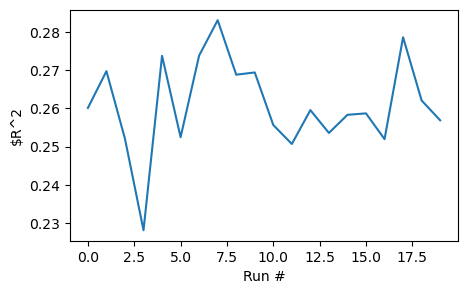

In [5]:
#R2 values - model fit
x = [res["target"] for res in clm_optimizer.res]

fig, ax = plt.subplots(1, 1, figsize = (5, 3))
ax.plot(x)
ax.set_xlabel('Run #')
ax.set_ylabel(r'$R^2')

In [6]:
def plot_gp_2D(optimizer, aq, it, param1, param2, param1_min, param1_max, param2_min, param2_max):
    #Setup 
    #Breakdown Data
    max_ = optimizer.max
    res = optimizer.res[:it]
    x_ = np.array([r["params"][param1] for r in res])
    y_ = np.array([r["params"][param2] for r in res])
    z_ = np.array([r["target"] for r in res])

    #Model Results
    ser = pd.Series(z_, index=[y_, x_])
    Z = ser.unstack().fillna(np.nan)

    #Range space
    x1 = np.linspace(param1_min, param1_max, 100).reshape(-1, 1)
    x2 = np.linspace(param2_min, param2_max, 100).reshape(-1, 1)
    xmesh, ymesh = np.meshgrid(x1, x2)
    xy = np.array(list(zip(xmesh.reshape(10000, 1), ymesh.reshape(10000, 1)))).reshape(10000,2)

    #Utility Function
    util = aq.utility(xy, optimizer._gp, 0)
    
    #Plot
    fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6,6))

    #Axis 1: Function Estimate
    mesh1 = axs.pcolormesh(Z.columns, Z.index,  Z, cmap=plt.cm.coolwarm)
    axs.scatter(x_, y_, c='white', s=80, edgecolors='black')
    axs.scatter(x_, y_, c='red', s=80, edgecolors='black')
    axs.scatter(max_["params"][param1], max_["params"][param2], s=80, c='green', edgecolors='black')

    axs.set_title('Function Estimate')
    axs.set_xlabel(param1)
    axs.set_ylabel(param2)

    axs.set_xlim(param1_min, param1_max)
    axs.set_ylim(param2_min, param2_max)

    fig.colorbar(mesh1, location = 'bottom', label = "Predicted Average Annual WTD")
    plt.show()

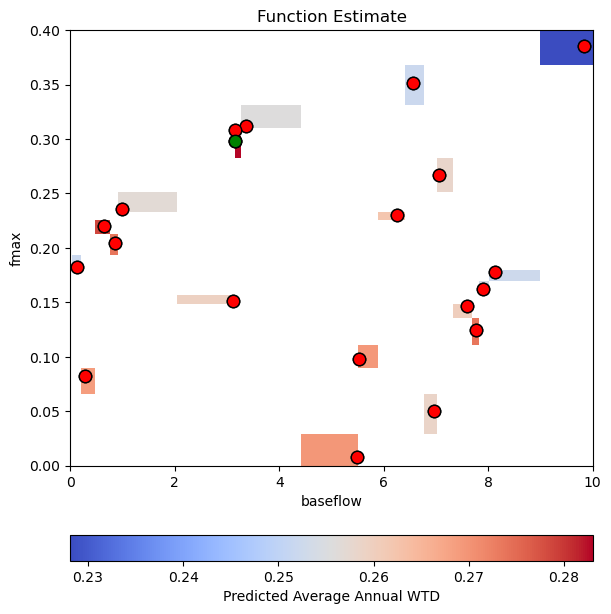

In [7]:
plot_gp_2D(clm_optimizer, acquisition_function, 70, 'baseflow', 'fmax', 0, 10, 0, 0.4)

In [8]:
clm_optimizer.res

[{'target': 0.26009330338005243,
  'params': {'baseflow': 7.601370568382025, 'fmax': 0.14647799931680192}},
 {'target': 0.26970724715818156,
  'params': {'baseflow': 5.489111757128916, 'fmax': 0.00803708531447538}},
 {'target': 0.25204242964423446,
  'params': {'baseflow': 0.12221613081773275, 'fmax': 0.18262737834496298}},
 {'target': 0.2281401952010722,
  'params': {'baseflow': 9.83118876475576, 'fmax': 0.3855760349851663}},
 {'target': 0.2737150115745676,
  'params': {'baseflow': 0.8620283704462894, 'fmax': 0.20442764472441555}},
 {'target': 0.25245453544272345,
  'params': {'baseflow': 8.13512808287183, 'fmax': 0.1774250800105225}},
 {'target': 0.27379613945036324,
  'params': {'baseflow': 7.7731724594813585, 'fmax': 0.12471159692447681}},
 {'target': 0.2830244266517892,
  'params': {'baseflow': 3.1617702510635812, 'fmax': 0.29790799504416593}},
 {'target': 0.26878784989330284,
  'params': {'baseflow': 0.28668862024697095, 'fmax': 0.08207186324885113}},
 {'target': 0.26937537652951

In [9]:
clm_optimizer.max

{'target': 0.2830244266517892,
 'params': {'baseflow': 3.1617702510635812, 'fmax': 0.29790799504416593}}